In [1]:
%matplotlib inline
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Process measured turbine data
- Data are resampled from 50 Hz to 1 Hz
- Bootstrapping performed with 10,000 trials to get descriptive statistics

In [2]:
refdatadir = '/Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements'
do_bootstrap = True

In [3]:
cases = {
    'neutral': '#008F00',
    'stable': '#003C60',
    'unstable': '#890001',
}

In [4]:
# for *WTGa1.csv data
outputs = {
    'GenPwr': 'Generator Power [kW]',
    'GenTq': 'Generator Torque [N-m]',
    'rotorRPM': 'Rotor Speed [rpm]',
}

In [5]:
def load_turbine_data(case):
    data = []
    #files = glob.glob(os.path.join(refdatadir, 'swift_{:s}_wtg_and_met_*.csv'.format(case)))
    files = glob.glob(os.path.join(refdatadir, 'swift_{:s}_*_WTGa1.csv'.format(case)))
    for i,fpath in enumerate(sorted(files)):
        print(case,i,fpath)
        df = pd.read_csv(fpath)
        df['datetime'] = pd.to_timedelta(df['datetime'])
        df['period'] = i
        df = df.pivot(index='datetime',columns='period')
        df = df.resample('1s').mean().stack()
        data.append(df)
    return pd.concat(data)

In [6]:
def make_bar_plots(df,color=None,stats=None,prefix=''):
    unstacked = df.unstack()
    all_mean = df.mean()
    period_mean = unstacked.mean()
    period_stdev = unstacked.std()

    ypos = df.index.unique(level='period')
    for output in df.columns:
        unstacked = df[output].unstack()
        fig,ax = plt.subplots()
        
        # bar plots by period
        mean = period_mean[output]
        stdev = period_stdev[output]        
        ax.barh(ypos, mean, xerr=stdev, color=color, align='center')
        
        # group statistics for these conditions
        if stats is None:
            allmean = all_mean[output]
            err = np.mean(stdev)
            outfile = prefix + output + '.png'
        else:
            allmean = stats.loc[output]['mean']
            err = stats.loc[output]['stdev']
            outfile = prefix + output + '_bootstrap.png'
        ax.axvline(allmean, color='k')
        ax.axvspan(allmean-err, allmean+err, color='0.5', alpha=0.5)
        ax.tick_params(labelsize='large')
        ax.set_ylabel('representative period',fontsize='x-large')
        ax.set_xlabel(outputs[output],fontsize='x-large')
        fig.savefig(outfile)

In [7]:
def bootstrap(dataseries,Ntrials=10000,seed=1234567):
    # combine all data
    N = len(dataseries)
    means = np.empty(Ntrials)
    stdevs = np.empty(Ntrials)
    randstate = np.random.RandomState(seed)
    for i in range(Ntrials):
        sample = dataseries.sample(n=N, replace=True, random_state=randstate)
        means[i] = np.mean(sample)
        stdevs[i] = np.std(sample)
    return means, stdevs

In [8]:
def check_stats(df):
    unstacked = df.unstack()
    
    # series with multiindex (output, period)
    period_mean = unstacked.mean()
    period_stdev = unstacked.std()
    print(pd.DataFrame({'mean':period_mean,'stdev':period_stdev}))
    
    # series with output as index
    mean_of_means = period_mean.unstack().mean(axis=1)
    mean_of_stdevs = period_stdev.unstack().mean(axis=1)
    print('\narithmetic mean:')
    print(pd.DataFrame({'mean':mean_of_means,'stdev':mean_of_stdevs}))
    
    # series with period as index
    means = period_mean.unstack(level=0)
    stdevs = period_stdev.unstack(level=0)
    N = len(stdevs)
    diffmean2 = []  # list of series with output as index
    for j in range(1,N):
        for i in range(j):
            # https://en.wikipedia.org/wiki/Pooled_variance#Population-based_statistics
            assert i<j
            diffmean2.append((means.loc[i] - means.loc[j])**2)
    pop_stdev = np.sqrt(
        np.sum(stdevs**2)/N + pd.concat(diffmean2,axis=1).sum(axis=1)/N**2
    )
    print('\npopulation-based stdev:')
    print(pop_stdev)

    # plot distribution of original data
    fig,ax = plt.subplots(ncols=len(df.columns),sharey=True,figsize=(11,4))
    for axi,output in zip(ax,df.columns):
        for i in df.index.unique(level='period'):
            df[output].xs(i,level='period').hist(ax=axi,alpha=0.3)
        axi.set_title(output)
           
    # do bootstrap and plot resulting distributions of means/stdevs (should be Gaussian!)
    figm,axm = plt.subplots(ncols=len(df.columns),sharey=True,figsize=(11,4))
    figs,axs = plt.subplots(ncols=len(df.columns),sharey=True,figsize=(11,4))
    bootstrap_mean, bootstrap_stdev = [], []
    for axmi,axsi,output in zip(axm,axs,df.columns):
        means,stdevs = bootstrap(df[output])
        axmi.hist(means,bins=25)
        axsi.hist(stdevs,bins=25)
        axmi.set_title('bootstrap mean({:s})'.format(output))
        axsi.set_title('bootstrap std({:s})'.format(output))
        bootstrap_mean.append(np.mean(means))
        bootstrap_stdev.append(np.mean(stdevs))
    stats = pd.DataFrame({'mean':bootstrap_mean,'stdev':bootstrap_stdev},
                         index=df.columns)
    print('\nbootstrap stats:')
    print(stats)
    return stats

neutral 0 /Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements/swift_neutral_evolution_00_WTGa1.csv
neutral 1 /Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements/swift_neutral_evolution_01_WTGa1.csv
neutral 2 /Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements/swift_neutral_evolution_02_WTGa1.csv
neutral 3 /Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements/swift_neutral_evolution_03_WTGa1.csv
neutral 4 /Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements/swift_neutral_evolution_04_WTGa1.csv
neutral 5 /Users/equon/WakeDynamics/wakebench_swift/wt_data/measurements/swift_neutral_evolution_05_WTGa1.csv
                       mean       stdev
         period                        
GenPwr   0        68.499760   24.982336
         1        83.740608   21.744868
         2        78.787995   19.619102
         3        79.301910   19.031316
         4        74.501893   13.430335
         5        89.601940   21.804447
GenTq    0       553

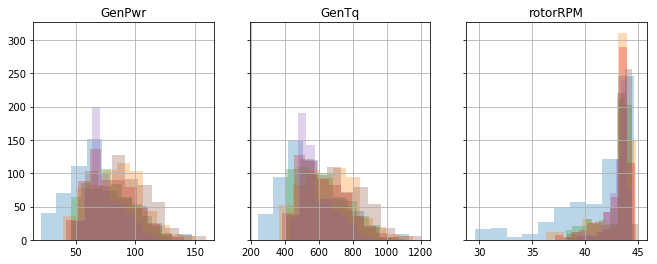

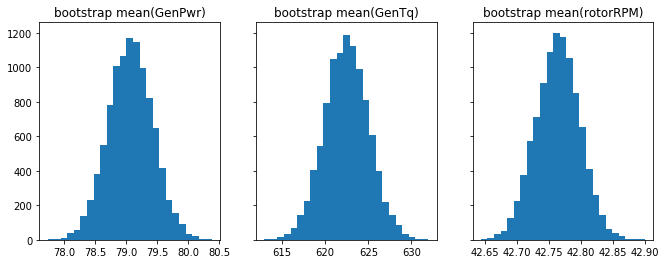

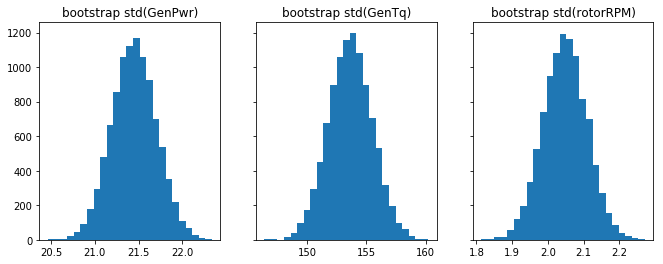

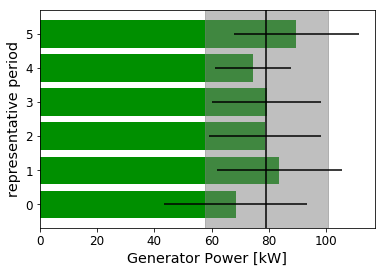

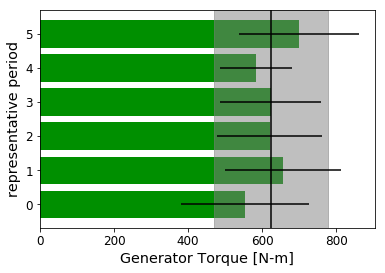

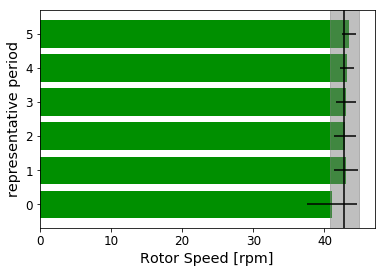

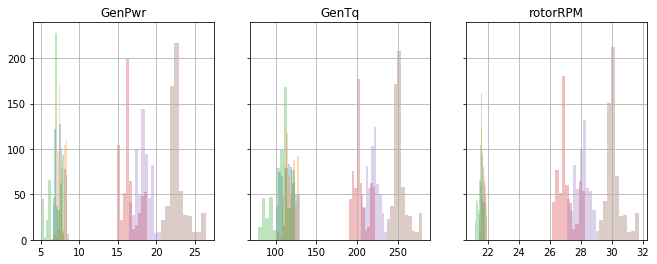

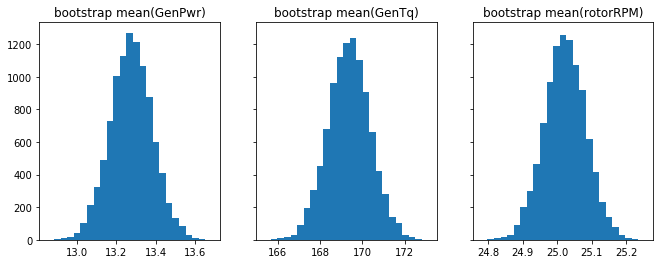

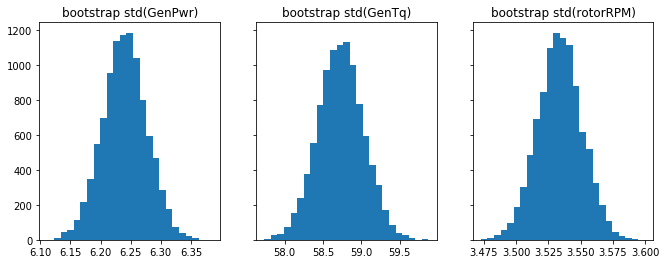

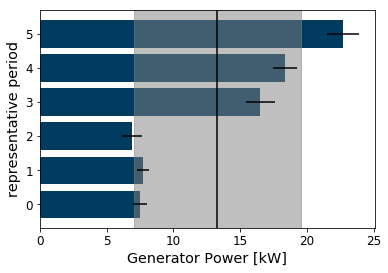

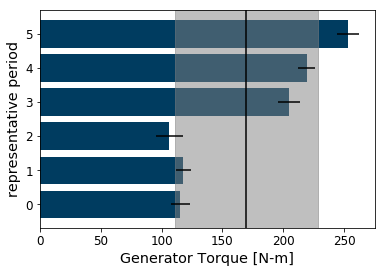

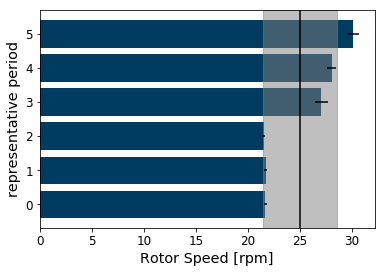

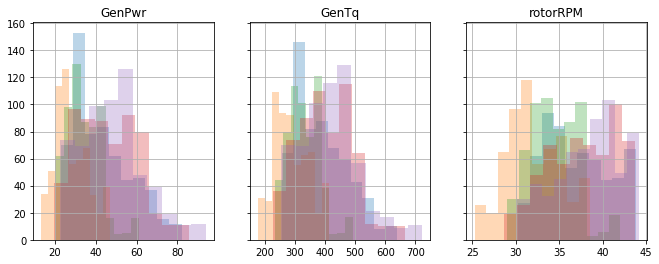

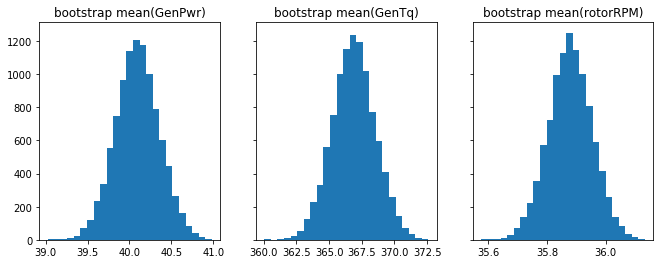

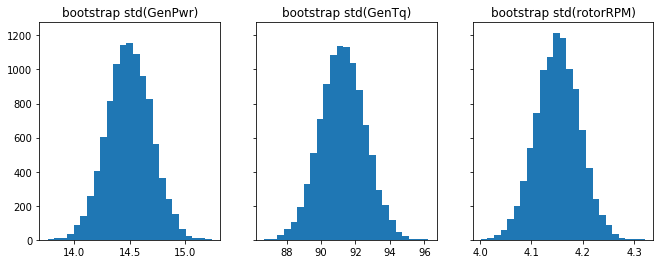

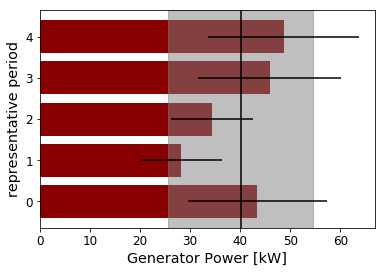

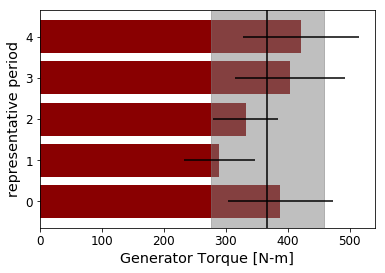

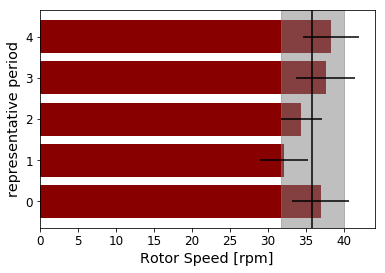

In [9]:
for cond in cases.keys():
    df = load_turbine_data(cond)
    if do_bootstrap:
        stats = check_stats(df)
        outfile = cond + '_bootstrap_stats.csv'
        print('Writing',outfile)
        stats.to_csv(os.path.join(refdatadir,outfile))
    else:
        stats = None
    make_bar_plots(df,color=cases[cond],stats=stats,prefix=cond+'_')
    print('======================================================')
